$\mathbf{Fast \ Fourier \ Transform}$ 

FFT transforms a signal from its time representation into the frequency domain by sampling data at fixed intervals and decomposing it into different frequencies. 

This algorithm recovers clusters by propagating waves through a graph. How does it use FFT on the local components. How does this work as a distributed system?


In [1]:
import numpy as np
from lib.spectral_clustering import similarity_matrix, laplacian_matrix, spectral_clustering
from lib.datasets import gaussian_mixture as gm
from lib.kmeans import kmeans
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib import cm

# Building Our Functions to Cluster with the Wave Equation

In [2]:
def array_to_binary(row):
    '''
    This function takes a row of 0's and 1's and turns it into binary, 
    backwards, so [0, 0, 1] becomes 4 
    '''
    binary_to_decimal = 0
    for i in range(len(row)):
        binary_to_decimal += row[i] * 2 ** i
    return binary_to_decimal

def cluster_wave_eq(k, T_max, num_nodes, c, normalized_laplacian):
    '''
    k = number of eigenvectors used, maybe??? < 2**k clusters
    T_max = number of iterations in time
    num_nodes = number of nodes in our graph
    c = constant in the wave equation. 0 < c < sqrt(2) for stability
    normalized_laplacian = D**{-1}L
    '''
    # initialize heat matrix: each row corresponds to a node, column corresponds to a step in time
    heat = np.zeros(shape = (num_nodes, T_max + 1)) #offset index by 1 because we need index -1, evolves with time
    #print(heat.shape)
    heat[:, 0] = np.random.uniform(size = num_nodes)
    heat[:, 1] = heat[:, 0] 
    #print(heat[:, 1].shape)
    # populate the heat matrix
    for i in range(2, T_max + 1): 
        heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])
    # calculate FFT for each node, the nth entry corresponds to e^(2pi ni/N) and encodes amplitude and phase shift
    heat_fft = np.fft.fft(heat, axis=1)
    # Finds the index of the k largest power over each row
    indices = np.argsort(-np.abs(heat_fft), axis = 1)[:k]
    eigenvector = np.zeros(shape = (num_nodes, k))
    binary = np.zeros(shape = (num_nodes, k))
    for i in range(num_nodes): # for each row, ie each node
        for j in range(k-1): # find the jth largest frequency
            eigenvector[i][j] = np.real(heat_fft[i][j])
            if eigenvector[i][j] > 0:
                binary[i][j] = 1
            else:
                binary[i][j] = 0
    cluster_num = [array_to_binary(binary[i]) for i in range(num_nodes)]
    return cluster_num


# Generating Data

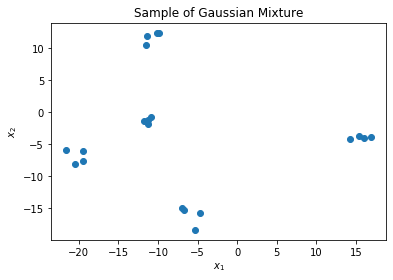

In [3]:
n_gaussians = 5
n_pts = 4
n = n_pts * n_gaussians
d = 2

data = gm(n_gaussians, n_pts, d, centroid_var=10)

plt.scatter(*data.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sample of Gaussian Mixture")
plt.show()

# Standard Graph Spectral Clustering

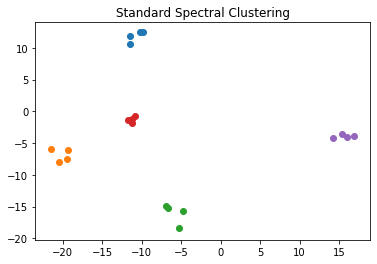

In [4]:
spectral = spectral_clustering(data, k=n_gaussians, lform="rw", metric = "g", s=1)
for i in range(len(spectral)):
    d = data[spectral == i].T
    x = d[0]
    y = d[1]
    plt.scatter(x,y)
plt.title("Standard Spectral Clustering")
plt.show()

# Hearing the Clusters

<ipython-input-2-f60cdc8d8f65>:27: RuntimeWarning: overflow encountered in matmul
  heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])
<ipython-input-2-f60cdc8d8f65>:27: RuntimeWarning: overflow encountered in multiply
  heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])
<ipython-input-2-f60cdc8d8f65>:27: RuntimeWarning: overflow encountered in subtract
  heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])
<ipython-input-2-f60cdc8d8f65>:27: RuntimeWarning: invalid value encountered in matmul
  heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])
<ipython-input-2-f60cdc8d8f65>:27: RuntimeWarning: invalid value encountered in subtract
  heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])


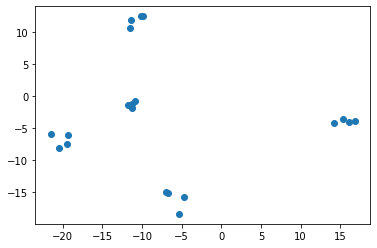

In [14]:
S = similarity_matrix(data)
L = laplacian_matrix(S)[0]
k = 3
T_max = 1000
c = 1.4
wave_cluster = cluster_wave_eq(k, T_max, n, c, L)

wave_assns = []
for i in range(len(wave_cluster)):
    wave_assns.append(int(wave_cluster[i]))
wave_assns = np.array(wave_assns)
for i in range(len(wave_assns)):
    d = data[wave_assns == i].T
    x = d[0]
    y = d[1]
    plt.scatter(x,y)